<a href="https://colab.research.google.com/github/SanjidaJahanTanha/Pneumonia-/blob/main/Copy_of_lesson_3_rsna_pneumonia_detection_challenge_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

## Lesson 3. RSNA Pneumonia Detection Challenge (Kaggel API)

The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

This notebook covers the basics of parsing the competition dataset, training using a detector basd on the [Mask-RCNN algorithm](https://arxiv.org/abs/1703.06870) for object detection and instance segmentation.  

This notebook is developed by [MD.ai](https://www.md.ai), the platform for medical AI.
This notebook requires Google's [TensorFlow](https://www.tensorflow.org/) machine learning framework.

**Intro to deep learning for medical imaging lessons**

- Lesson 1. Classification of chest vs. adominal X-rays using TensorFlow/Keras [Github](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) [Annotator](https://public.md.ai/annotator/project/PVq9raBJ)

- Lesson 2. Lung X-Rays Semantic Segmentation using UNets. [Github](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
[Annotator](https://public.md.ai/annotator/project/aGq4k6NW/workspace)

- Lesson 3. RSNA Pneumonia detection using Kaggle data format [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace)
  
- Lesson 3. RSNA Pneumonia detection using MD.ai python client library [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace)

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

In [ ]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images
!pip3 install -q pydicom
!pip3 install -q tqdm
!pip3 install -q imgaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import pydicom
import glob
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2
from skimage import exposure
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model
from collections import defaultdict

### First: Install Kaggle API for download competition data.

In [ ]:
# # Install Kaggle API for download competition data
# !pip3 install -q kaggle

### Next: You must accept the user agreement on the competition website! Then follow [instructions to obtain your Kaggle Credentials.](https://github.com/Kaggle/kaggle-api#api-credentials)  
If you are unable to download the competition dataset, check to see if you have accepted the **user agreement** on the competition website.

In [ ]:
# # enter your Kaggle credentionals here
# os.environ['KAGGLE_USERNAME']=""
# os.environ['KAGGLE_KEY']=""

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Set the path to the dataset
data_path = '/content/drive/MyDrive/rsna_pneumonia/'

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath(data_path)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [ ]:
# Load the CSV files
train_labels = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))

# Get the list of available images
available_images = os.listdir(os.path.join(ROOT_DIR, 'stage_2_train_images'))
available_image_ids = [os.path.splitext(image)[0] for image in available_images]

# Filter the train_labels DataFrame to include only available images
train_labels_filtered = train_labels[train_labels['patientId'].isin(available_image_ids)]

In [ ]:
# def parse_dataset(dicom_dir, anns):
#     image_fps = [os.path.join(dicom_dir, patient_id + '.dcm') for patient_id in anns['patientId'].unique()]
#     image_annotations = defaultdict(list)  # Initialize a defaultdict with list

#     for index, row in anns.iterrows():
#         fp = os.path.join(dicom_dir, row['patientId'] + '.dcm')
#         if not os.path.exists(fp):
#             print(f"File not found: {fp}")
#             continue
#         image_annotations[fp].append(row)

#     return image_fps, image_annotations

# train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
# anns = train_labels_filtered

# # Parse the dataset
# image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

# print("Parsed dataset successfully!")

In [ ]:
import os
import pandas as pd
from collections import defaultdict

def parse_dataset(dicom_dir, anns):
    image_fps = []
    image_annotations = defaultdict(list)

    # List of available DICOM files (without extensions)
    available_images = set(os.path.splitext(f)[0] for f in os.listdir(dicom_dir))

    for index, row in anns.iterrows():
        image_id = row['patientId']
        if image_id in available_images:
            fp = os.path.join(dicom_dir, image_id + '.dcm')
            image_fps.append(fp)
            image_annotations[fp].append(row)
        else:
            print(f"File not found: {os.path.join(dicom_dir, image_id + '.dcm')}")

    return image_fps, image_annotations

# Load and Filter the CSV Files
train_labels = pd.read_csv('/content/drive/MyDrive/rsna_pneumonia/stage_2_train_labels.csv')

# Directory containing the DICOM files
train_dicom_dir = '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images'

# Filter the train_labels DataFrame to include only available images
available_images = os.listdir(train_dicom_dir)
available_image_ids = [os.path.splitext(image)[0] for image in available_images]
train_labels_filtered = train_labels[train_labels['patientId'].isin(available_image_ids)]

# Parse dataset with filtered annotations
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=train_labels_filtered)

# Output the number of images found and the first few image paths and annotations
print(f"Number of images found: {len(image_fps)}")
print(f"First few image paths: {image_fps[:5]}")
print(f"First few annotations: {list(image_annotations.items())[:5]}")


Number of images found: 13974
First few image paths: ['/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm', '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm', '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm', '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm']
First few annotations: [('/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', [patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Na

### Data is downloaded as zip files. Unzip the test and train datasets as well as the csv of  annotations.

In [ ]:
# # unzipping takes a few minutes
# !unzip -q -o stage_1_test_images.zip -d stage_1_test_images
# !unzip -q -o stage_1_train_images.zip -d stage_1_train_images
# !unzip -q -o stage_1_train_labels.csv.zip

###  MD.ai Annotator

Additionally, If you are interested in augmenting the existing annotations, you can use the MD.ai annotator to view DICOM images, and create annotatios to be exported.  
MD.ai annotator project URL for the Kaggle dataset: https://public.md.ai/annotator/project/LxR6zdR2/workspace

**Annotator features**
- The annotator can be used to view DICOM images and create image and exam level annotations.
- You can apply the annotator to filter by label, adjudicate annotations, and assign annotation tasks to your team.
- Notebooks can be built directly within the annotator for rapid model development.
- The data wrangling is abstracted away by the interface and by our MD.ai library.
- Simplifies image annotation in order to widen the participation in the futrue of medical image deep learning.

The annotator allows you to create initial annotations, build and run models, modify/finetune the annotations based on predicted values, and repeat.  
The MD.ai python client library implements functions to easily download images and annotations and to prepare the datasets used to train the model for classification. See the following example notebook for parsing annotations and training using MD.ai annotator:
https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb  
- MD.ai URL: https://www.md.ai  
- MD.ai documentation URL: https://docs.md.ai/

In [ ]:
!pip install mdai
import mdai

# Authenticate using your MD.ai API token
client = mdai.Client(domain='public.md.ai', access_token='YOUR_ACCESS_TOKEN')

# Load the project and dataset
project = client.project('LxR6zdR2')
dataset = project.get_dataset('YOUR_DATASET_ID')

# Download and parse the annotations
dataset.download_files()
annotations = dataset.annotations

# Convert annotations to a DataFrame
annotations_df = annotations.to_dataframe()

# Merge annotations with the filtered labels
merged_annotations = pd.merge(train_labels_filtered, annotations_df, on='patientId', how='inner')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 37.8 MB/s eta 0:00:00


Exception: Authorization error. Make sure your access token is valid.

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [ ]:
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        ********************************************************************************
        Usage of dash-separated 'description-file' will not be supported in future
        versions. Please use the underscore name 'description_file' instead.

        This deprecation is overdue, please update your project and remove deprecated
        calls to avoid build errors in the future.

        See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
        ********************************************************************************

!!
  opt = self.warn_dash_deprecation(opt, section)
/usr/local/lib/python3.10/dist-packages/setuptools/dist.py:755: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        **************************

In [ ]:
# # Import Mask RCNN
# sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
# from mrcnn.config import Config
# from mrcnn import utils
# import mrcnn.model as modellib
# from mrcnn import visualize
# from mrcnn.model import log

ModuleNotFoundError: No module named 'keras.engine'

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import pydicom
import glob
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2
from skimage import exposure
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model

# Define the path to the model.py file
model_file_path = os.path.join(ROOT_DIR, 'Mask_RCNN', 'mrcnn', 'model.py')

# Read the content of the file
with open(model_file_path, 'r') as file:
    file_data = file.read()

# Replace keras import statements with tensorflow.keras
file_data = file_data.replace('import keras.backend as K', 'import tensorflow.keras.backend as K')
file_data = file_data.replace('import keras.layers as KL', 'import tensorflow.keras.layers as KL')
file_data = file_data.replace('import keras.models as KM', 'import tensorflow.keras.models as KM')
file_data = file_data.replace('import keras.engine as KE', 'from tensorflow.keras import Model as KE')
file_data = file_data.replace('KE.Layer', 'tf.keras.layers.Layer')  # Adjust Layer references

# Replace the string comparison
file_data = file_data.replace("if os.name is 'nt':", "if os.name == 'nt':")

# Write the changes back to the file
with open(model_file_path, 'w') as file:
    file.write(file_data)

print("Updated model.py to use tensorflow.keras and fixed string comparison")

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Rest of your code follows here...


Updated model.py to use tensorflow.keras and fixed string comparison
TensorFlow version: 2.15.0


In [ ]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [ ]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns):
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows():
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In [ ]:
# The following parameters have been selected to reduce running time for demonstration purposes
# These are not optimal

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """

    # Give the configuration a recognizable name
    NAME = 'pneumonia'

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    BACKBONE = 'resnet50'

    NUM_CLASSES = 2  # background + 1 pneumonia classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64

    RPN_ANCHOR_SCALES = (32, 64)

    TRAIN_ROIS_PER_IMAGE = 16

    MAX_GT_INSTANCES = 3

    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1

    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100


config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [ ]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset."""

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)

        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')

        # Add images
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp,
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale, convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool_), class_ids.astype(np.int32)


### Examine the annotation data, parse the dataset, and view dicom fields

In [ ]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [ ]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

Streaming output truncated to the last 5000 lines.
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d892dc96-5d2e-494e-b48d-a9f5c49f0fcb.dcm
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d894ff12-6d1c-4e18-a576-dd118a52f739.dcm
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d8959a46-82c0-40c4-8358-8fdb37f03c25.dcm
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d89f8d29-3832-4d89-8647-d16f9079c25a.dcm
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d8a4d7fd-37b4-4d9a-aed8-2648ebff3c0c.dcm
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d8a724c3-cd49-48b0-bff8-0f1e158f2706.dcm
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d8a9e6dc-7314-4ab7-b978-1b2879333bd0.dcm
File not found: /content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/d8a9fb54-e7a2-4d4c-bb20-63664144a01c.dcm
File not found: /cont

In [ ]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath
image = ds.pixel_array # get image array

In [ ]:
# show dicom fields
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets
**Note: We have only used only a portion of the images for demonstration purposes. See comments below.**

 - To use all the images do: image_fps_list = list(image_fps)
 - Or change the number of images from 100 to a custom number

In [ ]:
# Modify this line to use more or fewer images for training/validation.
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps[:12000])  # Adjust the number as per your uploaded files

# split dataset into training vs. validation dataset
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))


10800 1200


### Create and prepare the training dataset using the DetectorDataset class.

In [ ]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [ ]:
# Show annotation(s) for a DICOM image
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    526aa316-dc9e-4bec-a1e4-dcb7e6c4502e
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 6882, dtype: object]

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/63f71157-7db6-476f-b320-ba2fcbe2543f.dcm
[0]


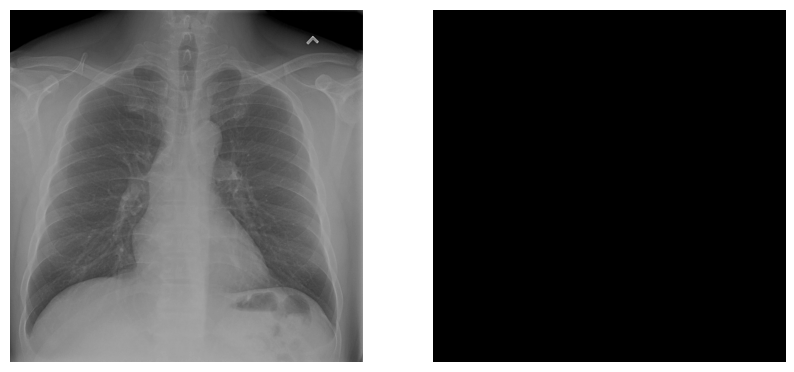

In [ ]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples.

import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples.

# Randomly select an image id from the training dataset
image_id = random.choice(dataset_train.image_ids)

# Get the file path for the image
image_fp = dataset_train.image_reference(image_id)

# Load the image
image = dataset_train.load_image(image_id)

# Load the mask and class IDs
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

# Display the image and its mask
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

# Image with mask
plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

# Make sure to replace np.bool with np.bool_ in the Mask RCNN code
# or simply use bool in the load_mask function.


In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

TypeError: Could not build a TypeSpec for KerasTensor(type_spec=TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None), name='tf.math.truediv/truediv:0', description="created by layer 'tf.math.truediv'") of unsupported type <class 'keras.src.engine.keras_tensor.KerasTensor'>.

### Image Augmentation. Try finetuning some variables to custom values

In [ ]:
# Image augmentation
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

NameError: name 'iaa' is not defined

### Now it's time to train the model. Note that training even a basic model can take a few hours.

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time.

- dataset_train and dataset_val are derived from DetectorDataset
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [ ]:
NUM_EPOCHS = 1

# Train Mask-RCNN Model
import warnings
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=NUM_EPOCHS,
            layers='all',
            augmentation=augmentation)

NameError: name 'model' is not defined

In [ ]:
# select trained model
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names:
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:

      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

NameError: name 'model' is not defined

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

AttributeError: Exception encountered when calling layer "roi_align_classifier" (type PyramidROIAlign).

in user code:

    File "/content/drive/MyDrive/rsna_pneumonia/Mask_RCNN/mrcnn/model.py", line 390, in call  *
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
    File "/content/drive/MyDrive/rsna_pneumonia/Mask_RCNN/mrcnn/model.py", line 341, in log2_graph  *
        return tf.log(x) / tf.log(2.0)

    AttributeError: module 'tensorflow' has no attribute 'log'


Call arguments received by layer "roi_align_classifier" (type PyramidROIAlign):
  • inputs=['tf.Tensor(shape=(1, None, 4), dtype=float32)', 'tf.Tensor(shape=(None, 14), dtype=float32)', 'tf.Tensor(shape=(None, None, None, 32), dtype=float32)', 'tf.Tensor(shape=(None, None, None, 32), dtype=float32)', 'tf.Tensor(shape=(None, None, None, 32), dtype=float32)', 'tf.Tensor(shape=(None, None, None, 32), dtype=float32)']

In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check.

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs.


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



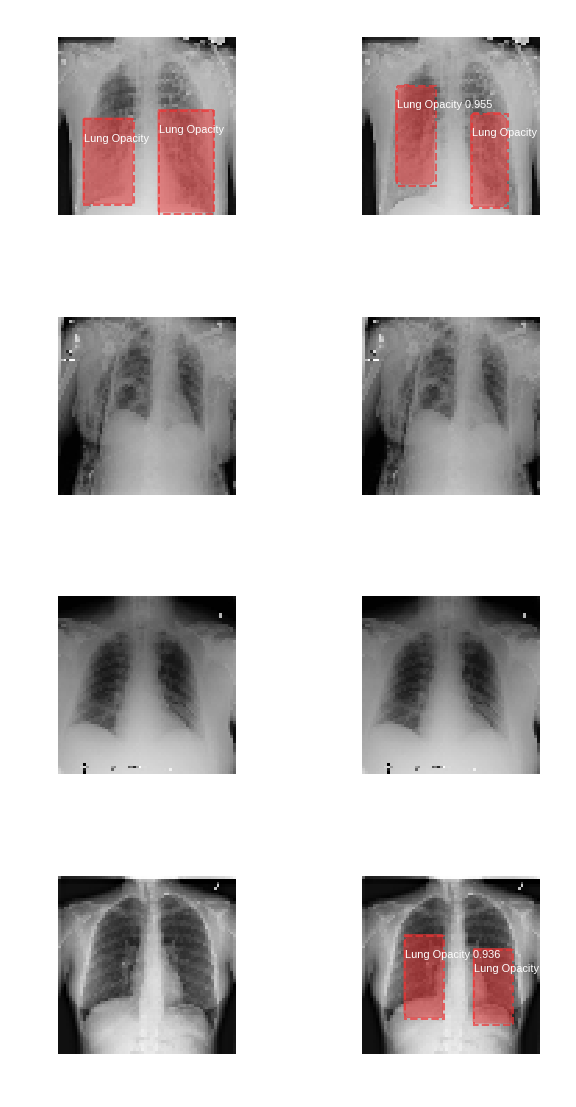

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])

    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'],
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [ ]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [ ]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='sample_submission.csv', min_conf=0.98):

    # assume square image

    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps):
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array

        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)

        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0:
            pass
        else:
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances):
                if r['scores'][i] > min_conf:
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1
                    height = r['rois'][i][2] - y1
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [ ]:
# predict only the first 50 entries
sample_submission_fp = 'sample_submission.csv'
predict(test_image_fps[:50], filepath=sample_submission_fp)

100%|██████████| 50/50 [00:06<00:00,  8.26it/s]


In [ ]:
#original code
# output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
# output.head(50)

,id,pred_string
0,0e245423-3ccd-41ee-84a5-b9f0a20dba71,NaN
1,1aeb19e3-7365-4d66-afef-5157a3aca280,NaN
2,0ffa20d5-7419-4c75-b821-be920771d2d4,NaN
3,242a6f0b-fc6e-42e6-84c9-f74e3d33372b,NaN
4,28eaff00-5fb7-40ee-8206-9d2ff5b081e0,NaN
5,1462ffd1-939b-49b7-9234-eeeb7f4986cc,NaN
6,1172e6d2-4207-4b90-b66e-bf2b3af86462,NaN
7,0e9d2259-5faa-4000-969c-f4d25d4eed0d,NaN
8,001916b8-3d30-4935-a5d1-8eaddb1646cd,NaN
9,12eddc6c-2d66-4df7-8da1-edd5b5fc81a9,NaN


In [ ]:
import pandas as pd

def predict(image_fps, filepath='sample_submission.csv', min_conf=0.98):
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")
        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array

            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id + ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                out_str += ""
            else:
                num_instances = len(r['rois'])
                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1, y1, width, height)
                        out_str += bboxes_str

            file.write(out_str+"\n")

# Call predict function
sample_submission_fp = 'sample_submission.csv'
predict(test_image_fps[:50], filepath=sample_submission_fp)

# Read the output CSV file
output = pd.read_csv(sample_submission_fp)
output.columns = ['id', 'pred_string']  # Rename columns if needed
output.head(50)
